![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Tratamiento de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelado
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

In [16]:
# Carga de datos de archivo .csv
data_train = pd.read_csv(r'C:\Users\dapen\OneDrive - Universidad de los andes\MIAD\Introducción Machine Learning\MIAD_NLP_2024\MIAD_NLP_2024\datasets\dataTrain_carListings.csv')
data_test = pd.read_csv(r'C:\Users\dapen\OneDrive - Universidad de los andes\MIAD\Introducción Machine Learning\MIAD_NLP_2024\MIAD_NLP_2024\datasets\dataTest_carListings.csv', index_col=0)

## Análisis Explortorio de datos

In [17]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB


In [18]:
# Datos ausentes
data_train.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

<Axes: ylabel='Price'>

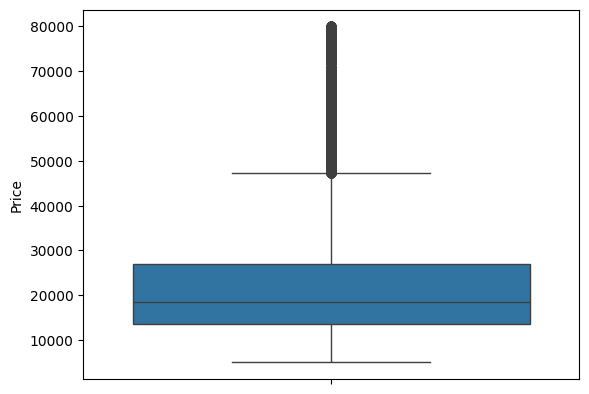

In [19]:
# Distribución de price
sns.boxplot(data_train, y = "Price")

## Modelado de datos

In [20]:
data_train.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [21]:
data_train = pd.get_dummies(data_train, columns=["State", "Make", "Model"])

In [23]:
# División de los datos en entrenamiento y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        data_train.drop(columns = "Price"),
                                        data_train["Price"],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = HistGradientBoostingRegressor(
            max_iter     = 10,
            loss         = "squared_error",
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

HistGradientBoostingRegressor(max_iter=10, random_state=123)

In [24]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 7735.429372621956


### Calibración

Valor óptimo de n_estimators: 451


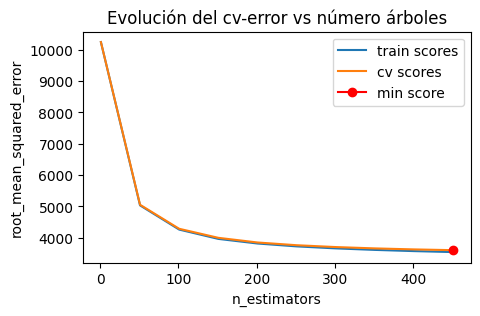

In [25]:
# Número de arboles
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_iter_range = range(1, 500, 50)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for max_iter in max_iter_range:
    
    modelo = HistGradientBoostingRegressor(
                max_iter     = max_iter,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_iter_range, train_scores, label="train scores")
ax.plot(max_iter_range, cv_scores, label="cv scores")
ax.plot(max_iter_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {max_iter_range[np.argmin(cv_scores)]}")


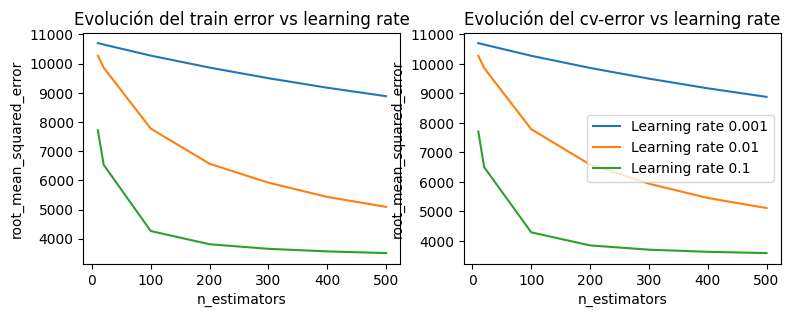

In [26]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
resultados = {}

# Valores evaluados
learning_rates_grid = [0.001, 0.01, 0.1]
max_iter_grid   = [10, 20, 100, 200, 300, 400, 500]


# Bucle para entrenar un modelo con cada combinacion de  learning_rate y n_estimator 
# y extraer su error de entrenamiento y k-cross-validation.
for learning_rate in learning_rates_grid:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in max_iter_grid:
    
        modelo = HistGradientBoostingRegressor(
                    max_iter      =  n_estimator,
                    learning_rate = learning_rate,
                    random_state  = 123
                 )

        # Error de train
        modelo.fit(X_train, y_train)
        predicciones = modelo.predict(X = X_train)
        rmse = mean_squared_error(
                y_true  = y_train,
                y_pred  = predicciones,
                squared = False
               )
        train_scores.append(rmse)

        # Error de validación cruzada
        scores = cross_val_score(
                    estimator = modelo,
                    X         = X_train,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # Se agregan los scores de cross_val_score() y se pasa a positivo
        cv_scores.append(-1*scores.mean())
        
    resultados[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Gráfico con la evolución de los errores de entrenamiento
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

for key, value in resultados.items():
    axs[0].plot(max_iter_grid, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("Evolución del train error vs learning rate")
    
    axs[1].plot(max_iter_grid, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("Evolución del cv-error vs learning rate")
    plt.legend();

Valor óptimo de max_depth: 20


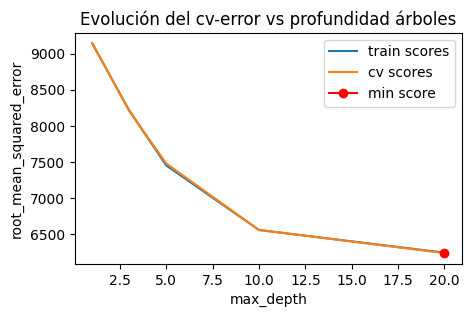

In [27]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_depths = [1, 3, 5, 10, 20]

# Bucle para entrenar un modelo con cada valor de max_depth y extraer su error
# de entrenamiento y de k-cross-validation.
for max_depth in max_depths:
    
    modelo = HistGradientBoostingRegressor(
                max_iter     = 25,
                max_depth    = max_depth,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolución del cv-error vs profundidad árboles")
plt.legend();
print(f"Valor óptimo de max_depth: {max_depths[np.argmin(cv_scores)]}")

In [28]:
# Grid Search
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'loss'             : ['squared_error', 'absolute_error'],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'max_depth'        : [3, 5, 10, 20],
              'l2_regularization': [0, 1, 10]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = HistGradientBoostingRegressor(
                        max_iter            = 1000, 
                        random_state        = 123,
                        # Activación de la parada temprana
                        early_stopping      = True,
                        validation_fraction = 0.1,
                        n_iter_no_change    = 10,
                        tol                 = 1e-7,
                        scoring             = 'loss',
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_l2_regularization,param_learning_rate,param_loss,param_max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
19,0,0.1,squared_error,20,-3511.996401,13.285651,-3358.720795,10.623083
67,10,0.1,squared_error,20,-3516.365873,16.263296,-3383.639848,4.363157
43,1,0.1,squared_error,20,-3521.377084,15.341278,-3379.639212,9.705533
18,0,0.1,squared_error,10,-3531.840242,15.907700,-3403.999136,8.857289


In [29]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'l2_regularization': 0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 20} : -3511.996401432076 neg_root_mean_squared_error


In [30]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3492.598594976367


In [35]:
print(predicciones)

[22544.0732808   3976.7058808  17872.81284427 ... 11903.65310938
 20213.88599012  8080.07286824]


In [37]:
y_pred = pd.DataFrame(predicciones, index=data_test.index, columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()

,Price
ID,
0,22544.073281
1,3976.705881
2,17872.812844
3,15128.417264
4,27400.704427


In [32]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

KeyboardInterrupt: 

In [33]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(data_train.shape[0]) * 75000 + 5000, index=data_train.index, columns=['Price'])
print(y_pred)

               Price
0       33090.508914
1       76303.572981
2       59899.545636
3       49899.386315
4       16701.398033
...              ...
399995  61261.121347
399996  25439.585885
399997  48169.152325
399998  72000.484342
399999  42681.698777

[400000 rows x 1 columns]


In [34]:
# Guardar predicciones en formato exigido en la competencia de kaggle


,Price
0,33090.508914
1,76303.572981
2,59899.545636
3,49899.386315
4,16701.398033
